### Load

In [23]:
import pickle
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
with open('../models/lasso.pkl', 'rb') as f:
    lasso:Lasso = pickle.load(f)
with open('../models/scalers/lasso_scaler.pkl', 'rb') as f:
    lasso_scaler:StandardScaler = pickle.load(f)

with open('../models/dt.pkl', 'rb') as f:
    dt:DecisionTreeRegressor = pickle.load(f)
with open('../models/scalers/dt_scaler.pkl', 'rb') as f:
    dt_scaler:StandardScaler = pickle.load(f)

with open('../models/gbt.pkl', 'rb') as f:
    gbt:GradientBoostingRegressor = pickle.load(f)
with open('../models/scalers/gbt_scaler.pkl', 'rb') as f:
    gbt_scaler:StandardScaler = pickle.load(f)

test_set = pd.read_csv('../data/7_model_specific_data_sets/test_with_outliers.csv')
test_no_out_set = pd.read_csv('../data/7_model_specific_data_sets/test_without_outliers.csv')

# lasso.predict()

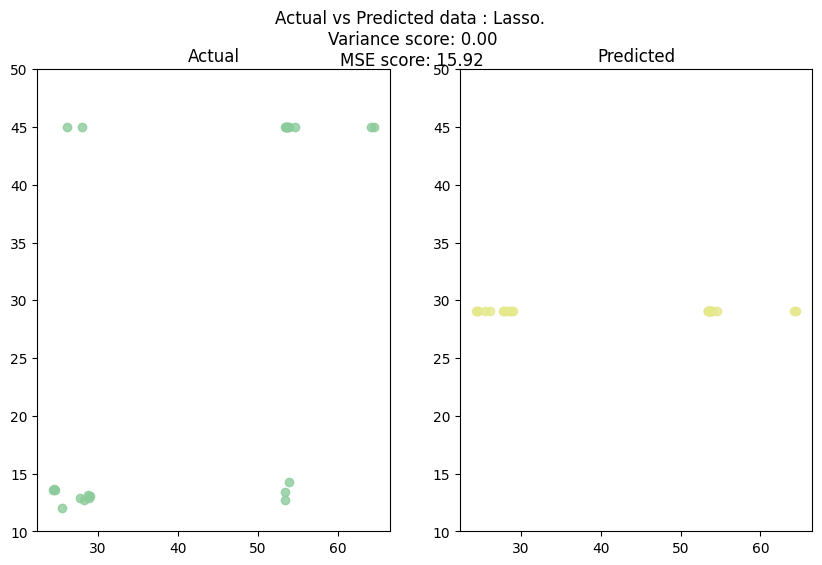

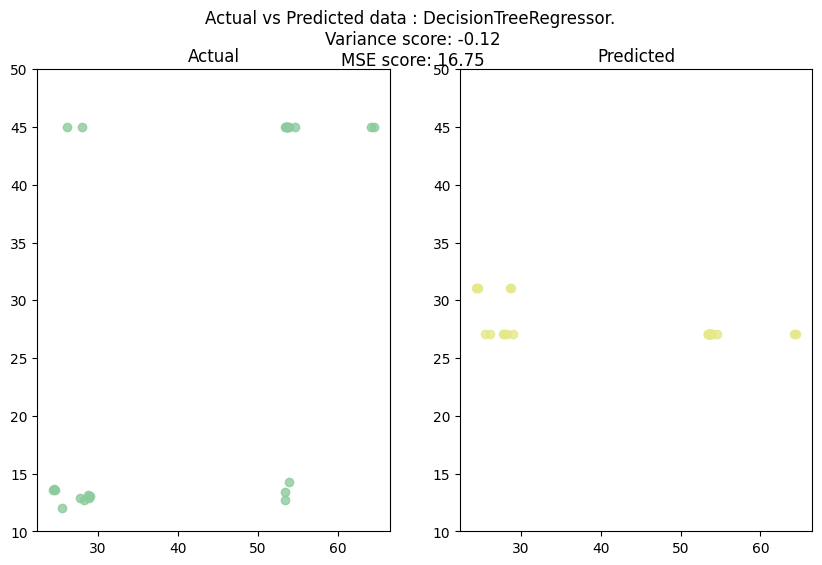

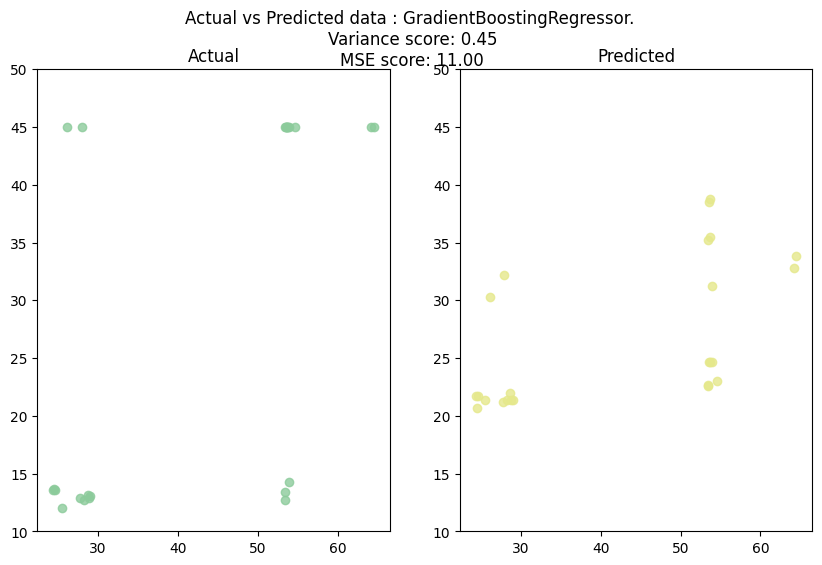

((24, 23), (24, 23))

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error as mse
def two_d_compare(X_test,y_test,y_pred,model_name):
    
    plt.subplots(ncols=2, figsize=(10,6))
    plt.suptitle('Actual vs Predicted data : ' +model_name + '. \nVariance score: %.2f' % r2_score(y_test, y_pred) +  '\nMSE score: %.2f' % mse(y_test, y_pred))
    plt.ylim([10, 50])
    plt.subplot(121)
    plt.scatter(X_test, y_test, alpha=0.8, color='#8CCB9B')
    plt.title('Actual')
    plt.ylim([10, 50])

    plt.subplot(122)
    plt.scatter(X_test, y_pred,alpha=0.8, color='#E5E88B')
    plt.title('Predicted')
    plt.show()
    
    
def predict(estimator, scaler:StandardScaler, df, n_cols):
    scaled_df = scaler.fit_transform(df)

    X = scaled_df[:, :n_cols]
    y_true = scaled_df[:, -1:]
    y_pred = estimator.predict(X).reshape(len(y_true), 1)
    pred = np.append(df.iloc[:, :-1].values, y_pred, axis=1)
    pred = scaler.inverse_transform(pred)

    two_d_compare(df.iloc[:, 0], df.iloc[:, -1], pred[:, -1],estimator.__class__.__name__)
    
    return scaled_df.shape, pred.shape

predict(lasso, lasso_scaler, test_set, 5)
predict(dt, dt_scaler, test_set, 2)
predict(gbt, gbt_scaler, test_set, 9)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score,mean_squared_error, r2_score
def two_d_compare(X_test,y_test,y_pred,model_name):
    area = (12 * np.random.rand(40))**2 
    plt.subplots(ncols=2, figsize=(10,4))
    plt.suptitle('Actual vs Predicted data : ' +model_name + '. Variance score: %.2f' % r2_score(y_test, y_pred))

    plt.subplot(121)
    plt.scatter(X_test, y_test, alpha=0.8, color='#8CCB9B')
    plt.title('Actual')

    plt.subplot(122)
    plt.scatter(X_test, y_pred,alpha=0.8, color='#E5E88B')
    plt.title('Predicted')

    plt.show()

def two_vs_three(x_test,y_test,y_pred,z=None, isLinear = False) : 
    
    area = 60
    

    fig = plt.figure(figsize=(12,6))
    fig.suptitle('2D and 3D view of sales price data')

    # First subplot
    ax = fig.add_subplot(1, 2,1)
    ax.scatter(x_test, y_test, alpha=0.5,color='blue', s= area)
    ax.plot(x_test, y_pred, alpha=0.9,color='red', linewidth=2)
    ax.set_xlabel('YEAR BUILT')
    ax.set_ylabel('SELLING PRICE')
    
    plt.title('YEARBUILT vs SALEPRICE')
    
    if not isLinear : 
    # Second subplot
        ax = fig.add_subplot(1,2,2, projection='3d')

        ax.scatter(z, x_test, y_test, color='blue', marker='o')
        ax.plot(z, x_test, y_pred, alpha=0.9,color='red', linewidth=2)
        ax.set_ylabel('YEAR BUILT')
        ax.set_zlabel('SELLING PRICE')
        ax.set_xlabel('LOT AREA')

    plt.title('LOT AREA vs YEAR BUILT vs SELLING PRICE')

    plt.show()